This Notebook details the process I took in approaching this Kaggle project

In [1]:
#imports
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import matplotlib as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
#load train and test data-sets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The first feature that is going to be transformed is the "Name" feature. Names don't directly predict someone's survival. However, there is value to be extracted in the titles of each passenger. As such, "Name" will be dropped in place of "Title"

In [3]:
def Title (name):
    index = name.find(",")
    a = index + 2
    return name[a:name.find(".")]

In [4]:
df_train['Title'] = df_train['Name'].apply(Title)
df_test['Title'] = df_test['Name'].apply(Title)

In [5]:
df_train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Title, dtype: int64

Seeing as there a few categories with less than 10 people under them, they should be grouped together to avoid being too specific. 'Mlle', 'Ms' and 'Mme' will also be replaced by their appropriate titles 

In [6]:
df_train = df_train.replace("Mlle", "Miss")
df_train['Title'] = df_train['Title'].replace('Ms', 'Miss')
df_train['Title']= df_train['Title'].replace('Mme', 'Mrs')
df_train = df_train.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','the Countess'], 'Rare')
df_test = df_test.replace("Mlle", "Miss")
df_test['Title'] = df_test['Title'].replace('Ms', 'Miss')
df_test['Title']= df_test['Title'].replace('Mme', 'Mrs')
df_test = df_test.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','the Countess'], 'Rare')

df_train["Title"].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

Now ticket and name will be dropped. A new feature called "Person" will be created for visualisation purposes. It will return the sex of the passenger if the passenger's age is over 18, and return child otherwise. This is to test the theory that children had significant priority to get be saved.

In [7]:
#pre-processing the data
def drop_features (df): #drop irrelevant features
    return df.drop(columns=["Name","Ticket"],inplace=True)
def person (passenger): #to test whether children have higher odds of survival
    age, sex = passenger
    if age > 18:
        return sex
    else:
        return "child"
drop_features(df_train)
drop_features(df_test)
df_train['Person'] = df_train[['Age','Sex']].apply(person,axis=1)
df_test['Person'] = df_test[['Age','Sex']].apply(person,axis=1)

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


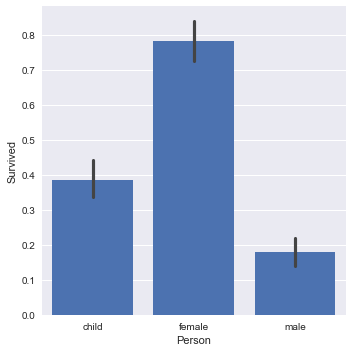

In [8]:
sns.factorplot(x='Person',y='Survived',data = df_train,kind='bar')

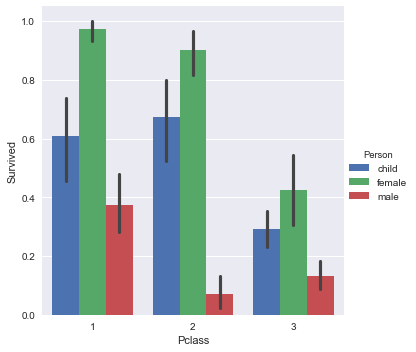

In [9]:
sns.factorplot("Pclass","Survived",data= df_train,hue='Person',kind='bar')

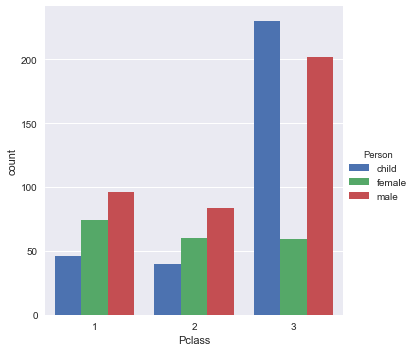

In [10]:
sns.factorplot(x='Pclass',data = df_train, hue = 'Person')

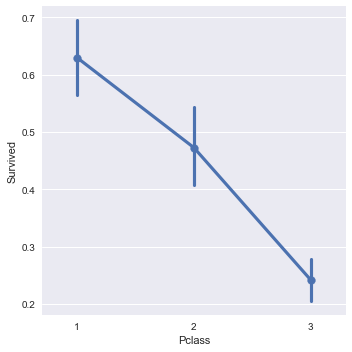

In [11]:
sns.factorplot(x='Pclass',y='Survived',data = df_train,)

It is clear that children and women have a higher survival rate compared to men. This could however be a function of not only their age, but also their passenger class.

In [12]:
df_train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Next, to avoid over-fitting the age feature, the feature will be binned into the 4 quartile ranges. Later, the ranges will be more experimented with to more logical bins to allow for better training

In [13]:
def bin_age(age): #binned age
    if age < 18:
        return '1'
    elif age < 32:
        return '2'
    elif age < 48:
        return '3'
    elif age < 64:
        return '4'
    elif age < 120:
        return '5'
df_train["Ref_Age"] = df_train["Age"].apply(bin_age)
df_test["Ref_Age"] = df_test["Age"].apply(bin_age)

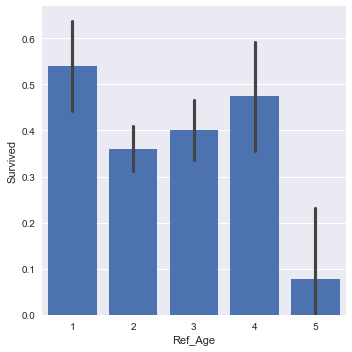

In [14]:
sns.factorplot(x='Ref_Age',y='Survived',data = df_train,kind='bar')

In [15]:
def bin_age(age): #binned age
    if age < 18:
        return '1'
    #elif age < 32:
     #   return '2'
    #elif age < 48:
      #  return '3'
    elif age < 64:
        return '2'
    elif age < 120:
        return '3'
df_train["Ref_Age"] = df_train["Age"].apply(bin_age)
df_test["Ref_Age"] = df_test["Age"].apply(bin_age)

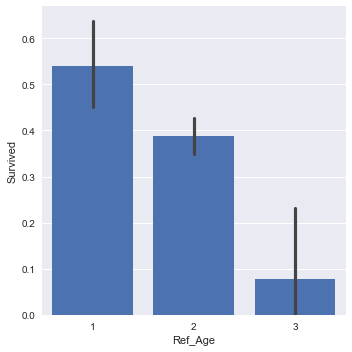

In [16]:
sns.factorplot(x='Ref_Age',y='Survived',data = df_train,kind='bar')

Although the Cabin feature has a lot of null values, it might be useful to investigate the relationship between a passenger's survival and which Cabin this passenger sat in

In [17]:
Cabin = df_train['Cabin']
Cabin.fillna('N',inplace=True)
levels = []
for level in Cabin:
    levels.append(level[0])
    
df_train['Cabin'] = levels

Cabin_test = df_test['Cabin']
Cabin_test.fillna('N',inplace=True)
levels = []
for level in Cabin_test:
    levels.append(level[0])
    

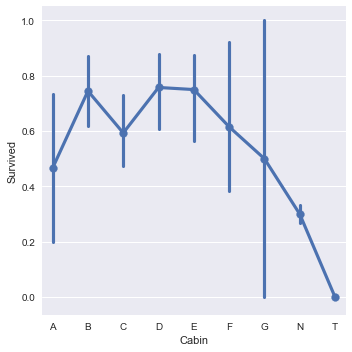

In [18]:
sns.factorplot(x = 'Cabin', y= 'Survived',data=df_train)

Without a way to conclusively determine the null values, it is seen that survival seems to be relatively uncorrelated with the Cabin. This feature will later be dropped.

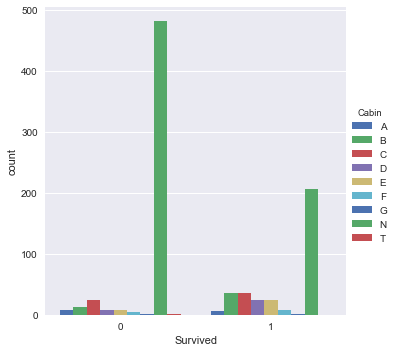

In [19]:
#Some visualisation
sns.factorplot("Survived",hue='Cabin',data=df_train)

As seen in this graph, it is very difficult to find a trend between Cabin and survival. While intuitively it may be a very good predictor, the number of null values make this feature a very poor predictor of survival.

In [20]:
df_train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

It might be useful to bin the fares into the quartile ranges.

In [21]:
def refined_fare(fare): #bin them into the percentile ranges
    if fare < 0:
        return ("Unknown")
    elif fare < 8:
        return ("1st")
    elif fare < 15:
        return ("2nd")
    elif fare < 31:
        return ("3rd")
    elif fare <515:
        return ("4th")
df_train["Fare"] = df_train["Fare"].apply(refined_fare)
df_test["Fare"] = df_test["Fare"].apply(refined_fare)

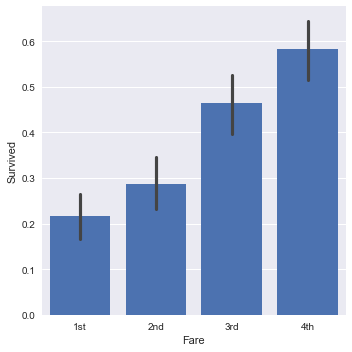

In [22]:
sns.factorplot(x = 'Fare', y= 'Survived',data=df_train,kind='bar')

There is a clear trend in fare price and a passenger's survival

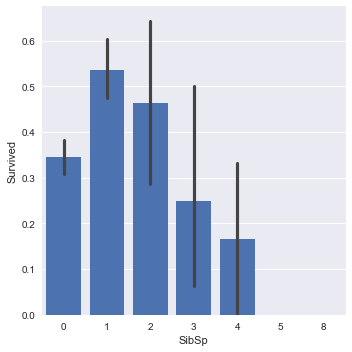

In [23]:
sns.factorplot(x = 'SibSp', y= 'Survived',data=df_train,kind='bar')

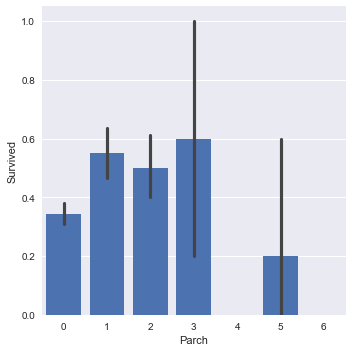

In [24]:
sns.factorplot(x = 'Parch', y= 'Survived',data=df_train,kind='bar')

The next features that will be transformed is the SibSp and Parch. From the graphs above, it seems the survival rate of people with more family members have less of a chance of survival. As such, these features will be combined into one feature called "Family Size" and these two features will be dropped.

In [25]:
df_train["Family_size"] = df_train.SibSp + df_train.Parch
df_test["Family_size"] = df_test.SibSp + df_test.Parch

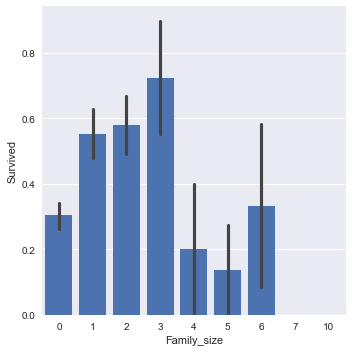

In [26]:
sns.factorplot(x = 'Family_size', y= 'Survived',data=df_train,kind='bar')

It might be useful to bin these family sizes to avoid overfitting. It seems there is a spike in survival rate if a passenger is not alone. This might be because passengers with kids or older parents travelling with them get priority.

In [27]:
def Family_size_bin (family_size):
    if (family_size < 1):
        return "alone"
    elif (family_size < 4):
        return "medium"
    elif (family_size <11):
        return "large"
df_train["Bin_Family_size"]= df_train["Family_size"].apply(Family_size_bin)
df_test["Bin_Family_size"]= df_test["Family_size"].apply(Family_size_bin)

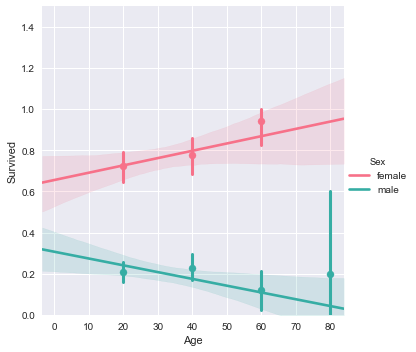

In [28]:
g = sns.lmplot("Age","Survived", hue = 'Sex',data = df_train, x_bins = [20,40,60,80])
g.set(ylim=(0,1.5))

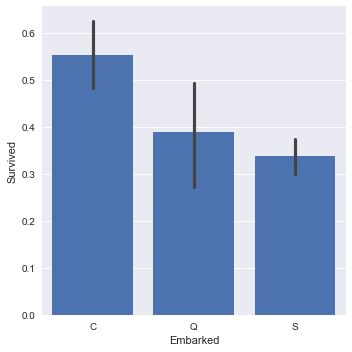

In [29]:
sns.factorplot(x='Embarked',y='Survived',data = df_train,kind='bar')

There is seems to be a correlation between where a passenger embarked and the survival of this passenger. This however may be simply correlated to the demographic group these passengers fell under. Let's test the correlation between age, sex, fare, family members and Pclass for all three embarkment points.

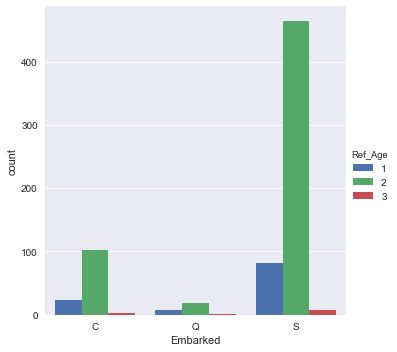

In [30]:
sns.factorplot(x='Embarked',hue = 'Ref_Age', data = df_train,kind='bar')

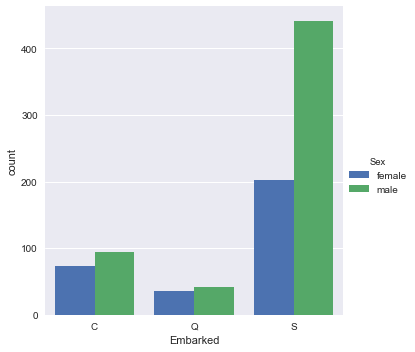

In [31]:
sns.factorplot(x='Embarked',hue = 'Sex', data = df_train,kind='bar')

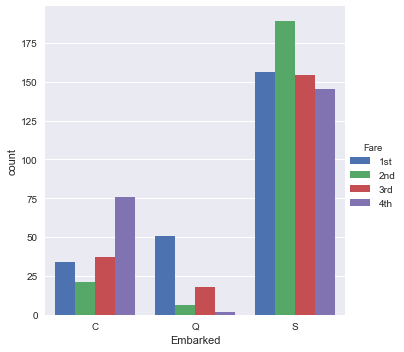

In [32]:
sns.factorplot(x='Embarked',hue = 'Fare', data = df_train,kind='bar')

It seems that passengers who embarked at Cherbourg and Southampton is more distributed in fares. Queenstown passengers seem to be more poor.

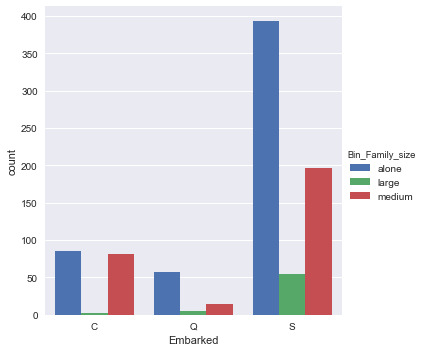

In [33]:
sns.factorplot(x='Embarked',hue = 'Bin_Family_size', data = df_train,kind='bar')

For all 3 embarkment points, it seems that alone passengers are the most common, followed by medium families (4 or less). Southampton is particular has a lot of passengers travelling alone.

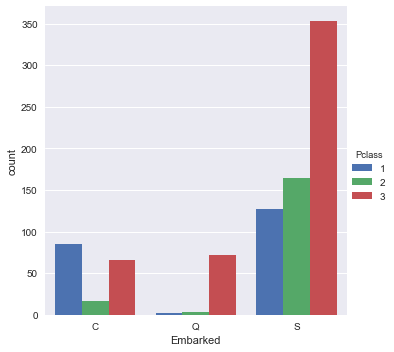

In [34]:
sns.factorplot(x='Embarked',hue = 'Pclass', data = df_train,kind='bar')

Lastly, Southampton seems to have the largest absolute number of Pclass 3 passengers, while Queenstown has the most relative amount of 3 Pclass passengers. Cherbourg is carrying more of a distributed array of passengers. 

As seen from the analysis above, some features like Sex, Family Size and Age seem to suggest Embarkment is independent of whether someone survived or not. Other features like Pclass and Fare seem to suggest otherwise. 

In [35]:
df_train= df_train.drop(["Age","SibSp","Person","Parch","Cabin",'Family_size','Cabin'],axis=1)
df_test= df_test.drop(["Age","SibSp","Person","Parch","Cabin",'Family_size','Cabin'],axis=1)


In [36]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Title,Ref_Age,Bin_Family_size
0,1,0,3,male,1st,S,Mr,2,medium
1,2,1,1,female,4th,C,Mrs,2,medium
2,3,1,3,female,1st,S,Miss,2,alone
3,4,1,1,female,4th,S,Mrs,2,medium
4,5,0,3,male,2nd,S,Mr,2,alone


In [37]:
from sklearn import preprocessing
def encode_features(train, test):
    features = ["Sex","Ref_Age",'Title',"Embarked","Bin_Family_size","Fare"]
    df_combined = pd.concat([df_train[features], df_test[features]]) 
    
    for feature in features: # the contents of the following for loop is modelled from the sklearn documentation
        LabelEncoder = preprocessing.LabelEncoder()
        LabelEncoder = LabelEncoder.fit(df_combined[feature])
        df_train[feature] = LabelEncoder.transform(df_train[feature])
        df_test[feature] = LabelEncoder.transform(df_test[feature])
    return df_train, df_test
    
df_train, df_test = encode_features(df_train, df_test)
df_train.head()

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Title,Ref_Age,Bin_Family_size
0,1,0,3,1,1,3,2,2,2
1,2,1,1,0,4,1,3,2,2
2,3,1,3,0,1,3,1,2,0
3,4,1,1,0,4,3,3,2,2
4,5,0,3,1,2,3,2,2,0


In [38]:
from sklearn.model_selection import train_test_split
#Create a test set to test the accuracy
#Drop the survived and passengerid feature. 
#PassengerID is uesless, Survived should not be in the training 
X_all = df_train.drop(["Survived", "PassengerId"], axis=1) 
Y_all = df_train['Survived']

num_test = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=num_test)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

clf = RandomForestClassifier(n_estimators=250,max_features=0.5,max_depth=10,min_samples_leaf=20)
clf.fit(X_train, Y_train)
test_predictions = clf.predict(X_test)
print(accuracy_score(Y_test,test_predictions))

0.77094972067


In [40]:
clf1 = RandomForestClassifier(n_estimators=150)
clf1.fit(X_all, Y_all)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
final_predictions = clf1.predict(X_test)
print(accuracy_score(Y_test,final_predictions))

0.837988826816


In [42]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_all,Y_all)
coeff_df = DataFrame(zip(X_all.columns, np.transpose(logistic_model.coef_)))
coeff_df

,0,1
0,Pclass,[-0.81396166657]
1,Sex,[-2.32293142845]
2,Fare,[0.0411607976495]
3,Embarked,[-0.181425330752]
4,Title,[-0.274268699364]
5,Ref_Age,[0.0269451854081]
6,Bin_Family_size,[0.215974909692]


In [43]:
from sklearn.svm import SVC
SVM = SVC(gamma=500)
SVM.fit(X_all,Y_all)
predictions2 = SVM.predict(X_all)
print(accuracy_score(Y_all, predictions2))

0.877665544332


In [44]:
from sklearn.cross_validation import KFold 
#following code is modelled after sklearn documentation
def kfold(model):
    kf = KFold(891, n_folds=10)
    accuracies = []
    fold = 0
    for train_index, test_index in kf:
        fold = fold + 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        Y_train, Y_test = Y_all.values[train_index], Y_all.values[test_index]
        model.fit(X_train, Y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, predictions)
        accuracies.append(accuracy)
        
        
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_accuracy = np.mean(accuracies)
    print("Mean Accuracy: {0}".format(mean_accuracy)) 

kfold(clf1)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fold 1 accuracy: 0.822222222222
Fold 2 accuracy: 0.85393258427
Fold 3 accuracy: 0.786516853933
Fold 4 accuracy: 0.876404494382
Fold 5 accuracy: 0.842696629213
Fold 6 accuracy: 0.831460674157
Fold 7 accuracy: 0.797752808989
Fold 8 accuracy: 0.741573033708
Fold 9 accuracy: 0.831460674157
Fold 10 accuracy: 0.831460674157
Mean Accuracy: 0.821548064919


In [45]:
ids = df_test['PassengerId']
predictions = clf1.predict(df_test.drop('PassengerId', axis=1))
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
#output.to_csv('output.csv', index = False)
output.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1
